# Logistic Regression

In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy as sp
import scipy.sparse.linalg as linalg
import scipy.cluster.hierarchy as hr
from scipy.spatial.distance import pdist, squareform

import sklearn.datasets as datasets
import sklearn.metrics as metrics
import sklearn.utils as utils
import sklearn.linear_model as linear_model
import sklearn.cross_validation as cross_validation
import sklearn.cluster as cluster
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

from patsy import dmatrices

import seaborn as sns
%matplotlib inline

/Users/markcrovella/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [1]:
%%html
<style>
 .container.slides .celltoolbar, .container.slides .hide-in-slideshow {
    display: None ! important;
}
</style>

%Set up useful MathJax (Latex) macros.
%See http://docs.mathjax.org/en/latest/tex.html#defining-tex-macros
%These are for use in the slideshow
$\newcommand{\mat}[1]{\left[\begin{array}#1\end{array}\right]}$
$\newcommand{\vx}{{\mathbf x}}$
$\newcommand{\hx}{\hat{\mathbf x}}$
$\newcommand{\vbt}{{\mathbf\beta}}$
$\newcommand{\vy}{{\mathbf y}}$
$\newcommand{\vz}{{\mathbf z}}$
$\newcommand{\R}{{\mathbb{R}}}$
$\newcommand{\vu}{{\mathbf u}}$
$\newcommand{\vv}{{\mathbf v}}$
$\newcommand{\vw}{{\mathbf w}}$
$\newcommand{\col}{{\operatorname{Col}}}$
$\newcommand{\nul}{{\operatorname{Nul}}}$
$\newcommand{\vb}{{\mathbf b}}$
$\newcommand{\va}{{\mathbf a}}$
$\newcommand{\ve}{{\mathbf e}}$
$\newcommand{\setb}{{\mathcal{B}}}$
$\newcommand{\rank}{{\operatorname{rank}}}$
$\newcommand{\vp}{{\mathbf p}}$

So far we have seen linear regression: a continuous valued observation is estimated as linear (or affine) function of the independent variables.

Today we will look at the following situation.

Imagine that you are observing a binary variable -- a 0/1 value.

That is, these could be pass/fail, admit/reject, Democrat/Republican, etc.

You believe that there is some __probability__ of observing a 1, and that probability is a function of certain independent variables.

So the key properties of a problem that make it appropriate for logistic regression are:
    
* What you can observe is a __categorical__ variable
* What you want to estimate is a __probability__ of seeing a particular value of the categorical variable.

## What is the probability I will be admitted to Grad School?

From http://www.ats.ucla.edu/stat/r/dae/logit.htm:

A researcher is interested in how variables, such as GRE (Graduate Record Exam scores), GPA (grade point average) and prestige of the undergraduate institution, effect admission into graduate school. The response variable, admit/don't admit, is a binary variable.

There are three predictor variables: __gre,__ __gpa__ and __rank.__ We will treat the variables gre and gpa as continuous. The variable rank takes on the values 1 through 4. Institutions with a rank of 1 have the highest prestige, while those with a rank of 4 have the lowest. 

In [1]:
# data source: http://www.ats.ucla.edu/stat/data/binary.csv
df = pd.read_csv('data/ats-admissions.csv') 
df.head(10)

NameError: name 'pd' is not defined

Let's look at how each independent variable affects admission probability.

First, __rank__:

In [2]:
plt.plot(df.groupby('rank').mean()['admit'],'o-')
plt.xlabel('Rank')
plt.ylabel('P[admit]')

NameError: name 'plt' is not defined

Next, __GRE__:

In [3]:
plt.plot(df.groupby('gre').mean()['admit'])
plt.xlabel('gre')
plt.ylabel('P[admit]')

NameError: name 'plt' is not defined

Finally, __GPA__ (for this visualization, we aggregate GPA into 10 bins):

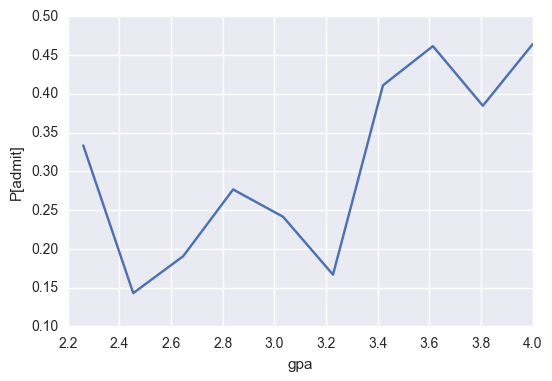

In [76]:
bins = np.linspace(df.gpa.min(), df.gpa.max(), 10)
groups = df.groupby(np.digitize(df.gpa, bins))
plt.plot(bins,groups.admit.mean())
plt.xlabel('gpa')
plt.ylabel('P[admit]')

In [4]:
train_cols = df.columns[1:]
train_cols

NameError: name 'df' is not defined

In [ ]:
Furthermore, we can see that the independent variables are strongly correlated:

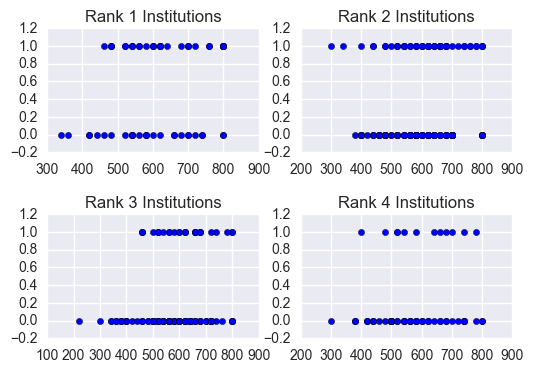

In [40]:
df1 = df[df['rank']==1]
df2 = df[df['rank']==2]
df3 = df[df['rank']==3]
df4 = df[df['rank']==4]
plt.subplot(221)
plt.scatter(df1['gre'],df1['admit'])
plt.title('Rank 1 Institutions')
plt.subplot(222)
plt.title('Rank 2 Institutions')
plt.scatter(df2['gre'],df2['admit'])
plt.subplot(223)
plt.scatter(df3['gre'],df3['admit'])
plt.title('Rank 3 Institutions')
plt.subplot(224)
plt.title('Rank 4 Institutions')
plt.scatter(df4['gre'],df4['admit'])
plt.subplots_adjust(hspace=0.5)

## Logistic Regression

Logistic regression is concerned with estimating a __probability.__

However, all that is available are 0/1 observations.

That is, these could be pass/fail, admit/reject, Democrat/Republican, etc.

Now, a linear function like $\alpha + \beta x$ cannot be used to predict probability directly, because the linear function takes on all values (from -$\infty$ to +$\infty$), and probability only ranges over $(0, 1)$.

However, there is a transformation of probability that works: it is called __log-odds__.

For any probabilty $p$, the __odds__ is defined as $p/(1-p)$.   Notice that odds vary from 0 to $\infty$, and odds < 1 indicates that $p < 1/2$.

Now, there is a good argument that to fit a linear function, instead of using odds, we should use log-odds.  That is simply $\log p/(1-p)$.

So, logistic regression does the following: it does a linear regression of $\alpha + \beta x$ against $\log p/(1-p)$.

That is, it fits:

$$\alpha + \beta x = \log p(x)/(1-p(x))$$

So:

$$e^{\alpha + \beta x} = p(x)/(1-p(x))$$

So:

$$e^{\alpha + \beta x} (1-p(x)) = p(x)$$

So: 

$$e^{\alpha + \beta x}  = p(x) + p(x)e^{\alpha + \beta x}$$

So:

$$\frac{e^{\alpha + \beta x}}{1 +e^{\alpha + \beta x}} = p(x)$$

So, logistic regression fits a probability of the following form:
        $$p(x) = P(y=1\mid x) = \frac{e^{\alpha+\beta x}}{1+e^{\alpha+\beta x}}$$
        
This is a sigmoid function; when $x\rightarrow \infty$, then $p(x)\rightarrow 1$ and when $x\rightarrow -\infty$, then $p(x)\rightarrow 0$.

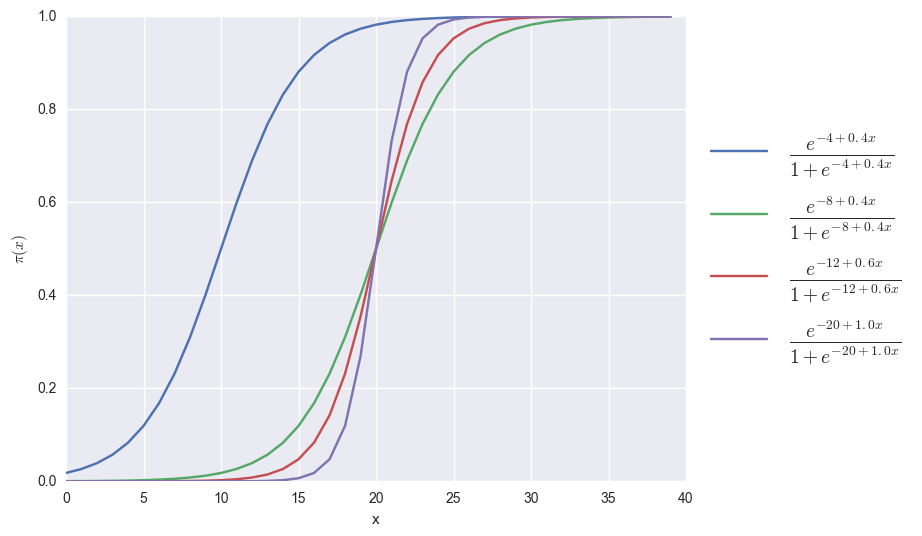

In [65]:
alphas = [-4, -8,-12,-20]
betas = [0.4,0.4,0.6,1]
x = np.arange(40)
fig = plt.figure(figsize=(8, 6)) 
ax = plt.subplot(111)

for i in range(len(alphas)):
    a = alphas[i]
    b = betas[i]
    y = np.exp(a+b*x)/(1+np.exp(a+b*x))
    plt.plot(x,y,label=r"$\frac{e^{%d + %3.1fx}}{1+e^{%d + %3.1fx}}$" % (a,b,a,b))
plt.xlabel('x')
plt.ylabel('$\pi(x)$')
_=ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 20})

Parameter $\beta$ controls how fast $\pi(x)$ raises from $0$ to $1$

The value of -$\alpha$/$\beta$ shows the value of $x$ for which $\pi(x)=0.5$


The function $f(x) = \log x/(1-x)$ is called the __logit__ function.

So a compact way to describe logisitic regression is that it finds regression coefficients $\alpha, \beta$ to fit:

$$\text{logit}\left(p(x)\right)=\log\left(\frac{p(x)}{1-p(x)} \right) = \alpha + \beta x$$


##### Logistic vs Linear regression

**Linear regression: ** $y_i = \alpha +\beta x_i$

$y_i$ comes from a normal distribution with standard deviation $\sigma$

$y_i=\alpha + \beta x_i$ is the linear predictor

**Logistic regression: ** The expected value of $E[y_i]$ *given* $x_i$ is $\pi_i=\pi(x_i)$ and $$\text{logit}\left(E[y_i]\right)=\text{logit}\left(\pi(x_i)\right)=\alpha + \beta x_i$$

$y_i\in\{0,1\}$ with $\text{Pr}(y_i=1)=\pi(x_i)$

#####  Logistic Regression Computation

**Input** pairs $(x_i,y_i)$

**Output** parameters $\widehat{\alpha}$ and $\widehat{\beta}$ that maximize the likelihood of the data given these parameters for the logistic regression model.

**Method** Maximum likelihood estimation

In [66]:
logit = sm.Logit(df['admit'], df[train_cols])
 
# fit the model
result = logit.fit() 

Optimization terminated successfully.
         Current function value: 0.586372
         Iterations 5


In [67]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      397
Method:                           MLE   Df Model:                            2
Date:                Mon, 07 Nov 2016   Pseudo R-squ.:                 0.06176
Time:                        21:49:36   Log-Likelihood:                -234.55
converged:                       True   LL-Null:                       -249.99
                                        LLR p-value:                 1.971e-07
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
gre            0.0015      0.001      1.420      0.155        -0.001     0.004
gpa           -0.0042      0.201     -0.021      0.983        -0.398     0.390
rank          -0.6695      0.121     -5.527      0.000        -0.907    -0.432
==============================================================================
"""

Some more information on performing logistic regression using the statmodels package can be found here:

http://blog.yhathq.com/posts/logistic-regression-and-python.html